In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="MIG-0bb056ed-239d-5614-a667-fd108c1880cf" 
from hydra.utils import instantiate
import yaml
import torch
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
device = "cuda:0"

In [2]:
torch.tensor(1).cuda()

tensor(1, device='cuda:0')

In [3]:
from src.data.get_datamodules import get_data
from cyto_dl.models.utils.mlflow import load_model_from_checkpoint
from src.models.save_embeddings import get_pc_loss

def get_data_and_models(dataset_name, batch_size):
    data = get_data(dataset_name, batch_size)
    data_list = [data[0], data[0], data[1], data[-2], data[-2]]

    run_ids = [
        "6bb8003c781e4661914a768763a352a3",
        "68157cde6680432292c3f5b959394bec",
        "e41f0bbf26944ba9b9e4541e87bf42f0",
        "358cef46219c435ab1b16d2a06dd4436",
    ]
    run_names = ["2048_ed_dgcnn", "2048_int_ed_vndgcnn", "classical_image", "so2_image"]
    all_models = []
    for i in run_ids:
        all_models.append(
            load_model_from_checkpoint(
                "https://mlflow.a100.int.allencell.org",
                i,
                path="checkpoints/val/loss/best.ckpt",
                strict=False,
            )
        )
    return data_list, all_models, run_names

In [4]:
dataset_name = 'pcna'
batch_size = 1
data_list, all_models, run_names = get_data_and_models(dataset_name, batch_size)

Jitting Chamfer 3D
Loaded JIT 3D CUDA chamfer distance
Loaded JIT 3D CUDA emd


In [5]:
run_names

['2048_ed_dgcnn', '2048_int_ed_vndgcnn', 'classical_image', 'so2_image']

In [6]:
all_models.reverse()
data_list.reverse()
run_names.reverse()

In [8]:
run_names

['so2_image', 'classical_image', '2048_int_ed_vndgcnn', '2048_ed_dgcnn']

In [ ]:
from src.models.save_embeddings import save_embeddings

debug = False
path = "./embeddings"
save_embeddings(path, data_list, all_models, run_names, debug)

In [9]:
from src.models.save_embeddings import save_emissions

debug = False
path = "./emissions_pcna"
save_emissions(path, data_list, all_models, run_names, 20, debug, device)

 16%|█▋        | 20/122 [01:29<07:34,  4.45s/it]


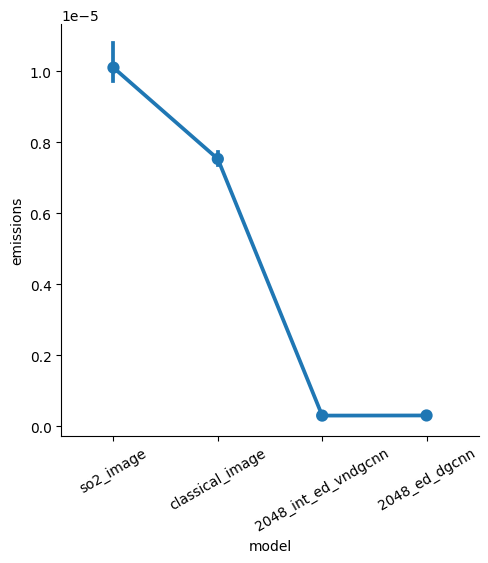

In [10]:
import pandas as pd
emissions = pd.read_csv(path + '/emissions.csv')
import seaborn as sns
g = sns.catplot(data=emissions,x='model', y='emissions', kind='point')
g.set_xticklabels(rotation=30)


In [73]:
from src.models.compute_features import compute_features

save_folder = './features_pcna/'
keys = ['image', 'image', 'pcloud', 'pcloud']
compute_features(
    dataset='pcna',
    save_folder=save_folder,
    data_list=data_list,
    all_models=all_models,
    run_names=run_names,
    keys=keys,
    device="cuda:0",
    max_embed_dim=256,
    class_label='cell_stage_fine',
    num_evolve_samples=40,
)

Computing rotation invariance


 62%|██████▎   | 5/8 [00:07<00:04,  1.48s/it]


Getting reconstruction
Computing compactness


100%|██████████| 4/4 [00:01<00:00,  2.20it/s]


Computing classification


100%|██████████| 4/4 [01:07<00:00, 16.81s/it]


Computing evolution


100%|██████████| 20/20 [00:13<00:00,  1.44it/s]
